<a href="https://colab.research.google.com/github/Revanthkrr-hub/projects/blob/master/1107178_1dconv_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
dataset=pd.read_csv('/content/housing.csv')
dataset=dataset.dropna()
print("first ten records of dataset ")
dataset.head(10)

first ten records of dataset 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


sub-plots of first eighteen samples from the dataset in a single figure.


numpy.ndarray

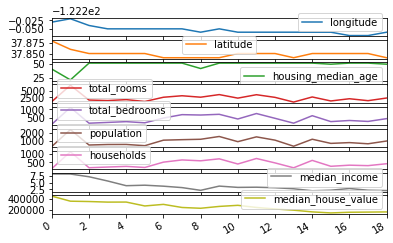

In [3]:
dataset1=dataset.loc[0:18,:]
#dataset1
graph1= dataset1.plot.line(subplots=True)
print("sub-plots of first eighteen samples from the dataset in a single figure.")
type(graph1)

sub-plots of all samples from the dataset in a single figure.


numpy.ndarray

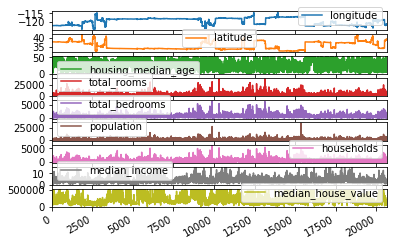

In [4]:
graph2= dataset.plot.line(subplots=True)
print("sub-plots of all samples from the dataset in a single figure.")
type(graph2)

In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']
# print(Y)
# print(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class cnnRegressor(torch.nn.Module):
  def __init__(self,batch_size, inputs, outputs):
    # initilize the super class & store the parameters
    super(cnnRegressor,self).__init__()
    self.batch_size= batch_size
    self.inputs= inputs
    self_outputs= outputs

    # define input  layers (input channels, output channels, kernel size)
    self.input_layer = Conv1d(inputs, batch_size,1)
    #(kernel size)
    self.max_pooling_layer= MaxPool1d(1)
    self.conv_layer= Conv1d(batch_size, 128,1)
    self.flatten_layer=Flatten()
    #(inputs, outputs)
    self.linear_layer= Linear(128,64)
    self.output_layer= Linear(64, outputs)

  def feed(self, input):
    #reshape the entry so it can fed to input layer
    input = input.reshape(self.batch_size, self.inputs,1)
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flatten_layer(output)
    output=self.linear_layer(output)
    output= self.output_layer(output)
    return output


In [8]:
#import SGD(stochastic gradient descent) package from pytroch for our optimizer
from torch.optim import SGD
#import mean aboslute error for our measure
from torch.nn import L1Loss

#import r^2 score package for score measure
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 7.0MB/s 


In [25]:
batch_size= 64
model= cnnRegressor(batch_size,X.shape[1],1)
#set the model to use the GPU for processing
model.cuda()

cnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train=False, optimizer= None):
  #cycle through batches and get avg L1loss
  performance=L1Loss()
  score_metric=R2Score()

  avg_loss=0
  avg_score=0
  count=0
  for input, output in iter(dataset):
    # get the model predictions for training dataset
    predictions=model.feed(input)
    #get the model loss
    loss= performance(predictions, output)
    #get the model r2 score
    score_metric.update([predictions,output])
    score= score_metric.compute()

    if(train):
      #clear any errors so that they dont commulate
      optimizer.zero_grad()
      #compute gradiennts for our optimizer
      loss.backward()
      # use the optimizer to update the model parameters based on gradients
      optimizer.step()

    avg_loss +=loss.item()
    avg_score +=score
    count +=1
  return avg_loss / count, avg_score/count


In [27]:
epochs=10
optimizer= SGD(model.parameters(), lr=1e-5)


inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader= DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score,= model_loss(model,loader,train=True, optimizer= optimizer)
  print("Epoch" + str(epoch +1)+ ":\n\tloss=" + str(avg_loss)+ "\n\tr^2 score=" + str(avg_r2_score))

Epoch1:
	loss=138514.93809557174
	r^2 score=-2.3129573508342216
Epoch2:
	loss=116525.06018778027
	r^2 score=-1.1169808645040324
Epoch3:
	loss=113992.46261911435
	r^2 score=-1.1067273800964852
Epoch4:
	loss=111350.04291619956
	r^2 score=-0.8294330241086019
Epoch5:
	loss=108081.01716647983
	r^2 score=-0.8672887193379841
Epoch6:
	loss=104799.8313831278
	r^2 score=-0.6627342410819648
Epoch7:
	loss=103923.17989770179
	r^2 score=-0.5702125117805195
Epoch8:
	loss=100992.10327914798
	r^2 score=-0.5270875929173808
Epoch9:
	loss=99231.78026905829
	r^2 score=-0.3164244388228608
Epoch10:
	loss=97838.83644548767
	r^2 score=-0.3685141296646603


In [36]:
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader= DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("the model l1 loss is :" + str(avg_loss))
print("the model r2 score is :" + str(avg_r2_score))

the model l1 loss is :85764.2451069079
the model r2 score is :0.010753159481308328
